<a href="https://colab.research.google.com/github/GutlapalliNikhil/Patch_Camelyon_Classification/blob/main/Patch_Camelyon_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Feb  5 02:57:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
(train_dataset, validation_dataset), ds_info = tfds.load(name="patch_camelyon",
                                                         split=["train", "validation"],
                                                         shuffle_files = True,
                                                         as_supervised = True,
                                                         with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete85YVI7/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete85YVI7/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete85YVI7/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds_info.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [5]:
class_names = ds_info.features["label"].names
class_names

['0', '1']

In [6]:
train_one_sample = train_dataset.take(1)
train_one_sample

<TakeDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>

In [7]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape},
  Image dtype : {image.dtype},
  Label : {label},
  Label name : {class_names[label]}
  """)


  Image Shape : (96, 96, 3),
  Image dtype : <dtype: 'uint8'>,
  Label : 1,
  Label name : 1
  


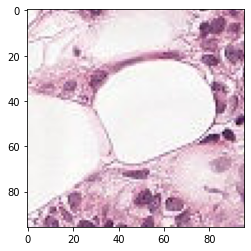

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [9]:
def preprocess_image(image, label):
  #image = image / 225
  return tf.cast(image, tf.float32), label

In [11]:
check_one_sample = train_dataset.take(1)
for image, label in check_one_sample:
  print(image)

tf.Tensor(
[[[[255. 245. 255.]
   [248. 232. 245.]
   [255. 251. 255.]
   ...
   [219. 164. 187.]
   [222. 170. 193.]
   [229. 180. 202.]]

  [[255. 248. 255.]
   [175. 161. 174.]
   [238. 227. 233.]
   ...
   [255. 200. 225.]
   [255. 207. 232.]
   [230. 182. 206.]]

  [[255. 250. 255.]
   [255. 247. 255.]
   [167. 154. 161.]
   ...
   [226. 173. 199.]
   [180. 132. 158.]
   [177. 133. 158.]]

  ...

  [[247. 247. 247.]
   [247. 247. 247.]
   [247. 247. 247.]
   ...
   [255. 237. 252.]
   [242. 214. 229.]
   [255. 245. 255.]]

  [[247. 249. 248.]
   [247. 249. 248.]
   [248. 250. 249.]
   ...
   [157. 119. 140.]
   [250. 211. 232.]
   [255. 225. 246.]]

  [[248. 250. 249.]
   [248. 250. 249.]
   [249. 251. 250.]
   ...
   [218. 173. 196.]
   [154. 109. 132.]
   [180. 132. 156.]]]


 [[[238. 236. 239.]
   [238. 236. 239.]
   [238. 236. 239.]
   ...
   [241. 236. 240.]
   [241. 236. 240.]
   [241. 236. 240.]]

  [[238. 236. 239.]
   [238. 236. 239.]
   [238. 236. 239.]
   ...
   [241. 2

In [10]:
train_dataset = train_dataset.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
validation_dataset = validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

data_aug = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.Rescaling(1./255)
], name = "data_aug")

In [40]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, MaxPool2D
from tensorflow.keras.models import Model

model = Sequential()
model.add(Conv2D(input_shape=(96,96,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=30,activation="relu"))
#model.add(Dense(units=10,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

In [41]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 73728)             0         
                                                                 
 dense_19 (Dense)            (None, 30)               

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [43]:
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=len(train_dataset),
                    validation_data=validation_dataset,
                    validation_steps=int(0.25 * len(validation_dataset)))

Epoch 1/10
8192/8192 [==============================] - 284s 34ms/step - loss: 0.8361 - accuracy: 0.7285 - val_loss: 0.5977 - val_accuracy: 0.7289
Epoch 2/10
8192/8192 [==============================] - 285s 35ms/step - loss: 0.4740 - accuracy: 0.7813 - val_loss: 0.5037 - val_accuracy: 0.7372
Epoch 3/10
8192/8192 [==============================] - 285s 35ms/step - loss: 0.4436 - accuracy: 0.7995 - val_loss: 0.6162 - val_accuracy: 0.7142
Epoch 4/10
8192/8192 [==============================] - 280s 34ms/step - loss: 0.4202 - accuracy: 0.8142 - val_loss: 0.5223 - val_accuracy: 0.7484
Epoch 5/10
8192/8192 [==============================] - 279s 34ms/step - loss: 0.4041 - accuracy: 0.8226 - val_loss: 0.5938 - val_accuracy: 0.7358
Epoch 6/10
8192/8192 [==============================] - 278s 34ms/step - loss: 0.3906 - accuracy: 0.8297 - val_loss: 0.5637 - val_accuracy: 0.7555
Epoch 7/10
8192/8192 [==============================] - 282s 34ms/step - loss: 0.3782 - accuracy: 0.8359 - val_loss: 0

In [44]:
loss, acc = model.evaluate(validation_dataset)

1024/1024 [==============================] - 26s 25ms/step - loss: 0.6541 - accuracy: 0.7516
